In [ ]:
# Install Pygam
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
# Import necessary libraries
import numpy as np
import numpy.random as rand
import random
import pandas as pd
import matplotlib.pyplot as plt
from types import MethodType
from arviz import hdi
import patsy as pt
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import beta, norm
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from scipy.integrate import quad
import seaborn as sns
import pickle
from pygam import LinearGAM, s as pygam_s
from scipy.special import expit
from tqdm import tqdm

plt.style.use('dark_background')
np.random.seed(42)
import sys
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

def progress_bar(i, max_i, length=50):
    progress = (i + 1) / max_i
    bar_length = int(length * progress)
    bar = '=' * bar_length + '-' * (length - bar_length)
    sys.stdout.write(f'\r[{bar}] {int(progress * 100)}%')
    sys.stdout.flush()

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# Set the seed value
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)


## Discrete Evolution

In [ ]:
# Define the agent class
class Agent:
    def __init__(self, variant):
        self.variant = variant
    def change_variant(self):
        if self.variant == 0:
            self.variant = 1
        else:
            self.variant = 0

In [ ]:
# Define the model class
class Model:
    def __init__(self, agent, size, init_p):
        self.agent = agent
        self.size = size
        self.init_p = init_p

    def populate(self):
        arr = []
        arr_loc = []
        for i in range(np.round(self.size * self.init_p).astype(int)):
            arr.append(self.agent(1))
            arr_loc.append(0)
        for i in range(self.size - len(arr)):
            arr.append(self.agent(0))
            arr_loc.append(0)
        return arr, arr_loc

    def get_variants(self, surface):
        return [x.variant for x in surface]

    def run(self, num_iter, splinevals):
        self.surface, self.location = self.populate()
        self.record = []

        for tick in range(num_iter):
            self.updatelist = list(range(len(self.surface)))
            self.updatelist2 = list(range(len(self.surface)))
            random.shuffle(self.updatelist)
            random.shuffle(self.updatelist2)

            for idx, updateind in enumerate(self.updatelist):
                agent1 = self.surface[updateind]
                agent2 = self.surface[self.updatelist2[idx]]
                if agent1.variant != agent2.variant:
                    zero_one = splinevals[tick]
                    one_zero = 1 - splinevals[tick]
                    if agent1.variant == 0 and agent2.variant == 1 and random.random() < zero_one:
                        agent1.change_variant()
                    elif agent1.variant == 1 and agent2.variant == 0 and random.random() < one_zero:
                        agent1.change_variant()

            metric1 = np.mean(self.get_variants(self.surface))
            self.record.append(metric1)

    def inference(self, data, n_runs, num_iter, priors):
        self.samples = []
        self.samplescore = []
        self.params = []
        self.smooths = []
        s, intercept, smoothparam, z_scores = priors

        # Generate spline basis
        basis = np.linspace(0, num_iter, num_iter)

        for run in range(n_runs):
            choice = random.randint(0, len(s) - 6)
            s_c, intercept_c, smoothparam_c = s[choice], intercept[choice], smoothparam[choice]

            splinevals = expit(intercept_c + np.sum(basis[:, None] * z_scores[choice:choice+6] * smoothparam_c, axis=1))

            self.run(num_iter, splinevals)
            self.samples.append(np.array(self.record))
            loss = np.exp(np.mean((np.array(self.record) - np.array(data))**2))
            self.samplescore.append(loss)
            self.params.append([s_c, intercept_c, smoothparam_c])
            self.smooths.append(splinevals)

    def postsummary(self, percentile, ci):
        accepted_idx = np.where(self.samplescore < np.percentile(self.samplescore, percentile))[0]
        self.accepted_params = np.asarray([x for i, x in enumerate(self.params) if i in accepted_idx])
        self.accepted_samples = [x for i, x in enumerate(self.samples) if i in accepted_idx]
        self.accepted_samplescores = [x for i, x in enumerate(self.samplescore) if i in accepted_idx]
        self.accepted_smooths = [x for i, x in enumerate(self.smooths) if i in accepted_idx]
        self.hdis = []
        self.parammeans = []

        for i in range(np.shape(self.params)[1]):
            self.hdis.append(hdi(self.accepted_params[:, i], ci))
            self.parammeans.append(np.mean(self.accepted_params[:, i]))

        print("Parameter Means:", self.parammeans)
        print("Highest Density Intervals:", self.hdis)


In [ ]:
# Load the dataset
df = pd.read_csv('/content/section1_data1.csv')

Parameter Means: [1.0023155587532202, 0.3044292197047355, 2.908158346360013]
Highest Density Intervals: [array([-0.93442943,  2.94233971]), array([1.19853669e-05, 9.07324608e-01]), array([3.98048235e-04, 8.74356986e+00])]
Accepted Parameters:
[[-8.97329426e-01  9.57937420e-03  9.33283428e-01]
 [ 2.65504222e+00  4.12539508e-02  6.08590339e-01]
 [ 1.04874168e+00  3.56189784e-01  1.16688441e+01]
 ...
 [ 1.06831130e+00  9.75521003e-02  1.88743917e+00]
 [ 2.01317130e+00  2.77971592e-01  1.02021283e+01]
 [ 1.09834230e+00  1.22972757e-01  1.35789467e+01]]


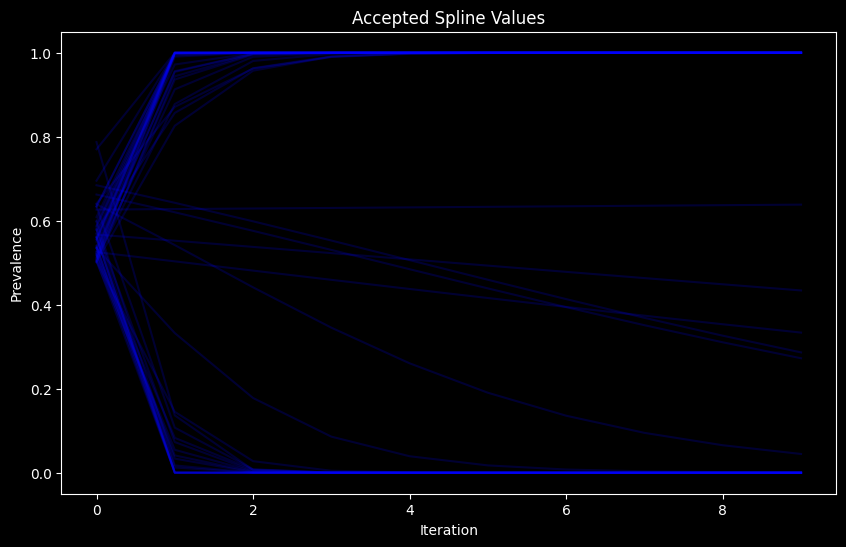

In [ ]:
# Initialize the model
mymodel = Model(Agent, size=100, init_p=0.1)

# Define priors for the parameters
mypriors = [
    np.random.normal(1, 1, 200000),            # Prior for s
    np.random.exponential(0.3, 200000),        # Prior for intercept
    np.random.exponential(3, 200000),          # Prior for smoothparam
    np.random.normal(0, 1, 200000)             # Prior for z_scores
]

# Extract the observed data (frequencies of variant 1) from column A
data = df['A'].to_numpy()

# Run inference
n_runs = 10000      # Number of simulation runs to sample from the prior
num_iter = len(df)      # Number of iterations per simulation
mymodel.inference(data, n_runs=n_runs, num_iter=num_iter, priors=mypriors)

# Summarize posterior results
percentile = 95  # Accept the top 5% of runs based on loss score
ci = 0.95        # 95% confidence interval
mymodel.postsummary(percentile, ci)

# Output results
print("Accepted Parameters:")
print(mymodel.accepted_params)

# Plot accepted smooth splines
plt.figure(figsize=(10, 6))
for smooth in mymodel.accepted_smooths[:50]:  # Plot the first 50 accepted smooth splines
    plt.plot(smooth, alpha=0.2, color='blue')

plt.title("Accepted Spline Values")
plt.xlabel("Iteration")
plt.ylabel("Prevalence")
plt.show()


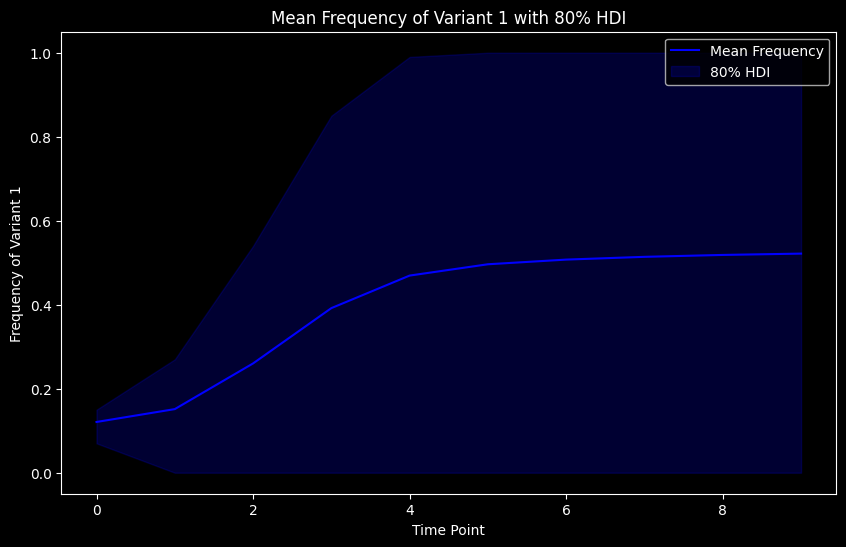

In [ ]:
# Define a function to calculate the HDI for a set of data
def compute_hdi(data, ci=0.8):
    """
    Compute the highest density interval (HDI) for a set of data.
    :param data: Array of data points.
    :param ci: Credible interval (default is 0.8 for 80%).
    :return: Lower and upper bounds of the HDI.
    """
    sorted_data = np.sort(data)
    interval_index = int(np.floor(ci * len(sorted_data)))
    n_intervals = len(sorted_data) - interval_index
    hdi_bounds = [
        (sorted_data[i], sorted_data[i + interval_index])
        for i in range(n_intervals)
    ]
    width = [bound[1] - bound[0] for bound in hdi_bounds]
    min_width_idx = np.argmin(width)
    return hdi_bounds[min_width_idx]

# Compute mean and HDI at each time point
all_samples = np.array(mymodel.accepted_samples)
mean_frequency = np.mean(all_samples, axis=0)
hdi_bounds = [compute_hdi(all_samples[:, t], ci=0.8) for t in range(all_samples.shape[1])]
hdi_lower, hdi_upper = zip(*hdi_bounds)

# Plot mean frequency and HDI
plt.figure(figsize=(10, 6))
plt.plot(mean_frequency, label='Mean Frequency', color='blue')
plt.fill_between(range(len(mean_frequency)), hdi_lower, hdi_upper, color='blue', alpha=0.2, label='80% HDI')
plt.title('Mean Frequency of Variant 1 with 80% HDI')
plt.xlabel('Time Point')
plt.ylabel('Frequency of Variant 1')
plt.legend()
plt.show()


In [ ]:
# Create a DataFrame for the parameter estimates
parameter_estimates = pd.DataFrame({
    "Parameter": ["s", "intercept", "smoothparam"],
    "Mean": mymodel.parammeans,
    "HDI Lower": [hdi[0] for hdi in mymodel.hdis],
    "HDI Upper": [hdi[1] for hdi in mymodel.hdis]
})

# Display the DataFrame
parameter_estimates


,Parameter,Mean,HDI Lower,HDI Upper
0,s,1.002316,-0.934429,2.942340
1,intercept,0.304429,0.000012,0.907325
2,smoothparam,2.908158,0.000398,8.743570


Smoothness and Adaptation: The smooth parameter governs how gradually the population adapts to changes in interaction probabilities. A lower smoothness value suggests abrupt changes, while higher values suggest more gradual adaptation.

Baseline Interaction Probability: The intercept represents the inherent bias in interaction dynamics (e.g., predisposition towards a specific variant). It contextualizes how often agents initially change states due to their interaction probabilities.

Temporal Dynamics: The smoothparam shows how interactions change over time, providing insights into whether the model suggests stability or variability in the prevalence of each variant.



## Social Dynamics

In [ ]:
#Define the agent class with variant vectors
class Agent:
    def __init__(self, variant_vector, age=None, susceptibility=None):
        self.variant_vector = variant_vector
        self.age = age
        self.susceptibility = susceptibility

    def change_variant(self):
        if self.variant_vector == [1, 0]:
            self.variant_vector = [0, 1]
        elif self.variant_vector == [0, 1]:
            self.variant_vector = [1, 0]


In [ ]:
# Define the model class
class Model:
    def __init__(self, agent_class, init_size, init_p):
        self.agent_class = agent_class
        self.size = init_size
        self.init_p = init_p

    def populate(self, susceptibility):
        arr = []
        for i in range(np.round(self.size * self.init_p).astype('int')):
            arr.append(self.agent_class([1, 0], np.round(np.random.uniform(0, 80, 1)[0]), np.random.normal(susceptibility, 0.05)))
        for i in range(self.size - len(arr)):
            arr.append(self.agent_class([0, 1], np.round(np.random.uniform(0, 80, 1)[0]), np.random.normal(susceptibility, 0.05)))
        return arr

    def birth(self, parents, nbirth):
        parent_chosen = random.sample(parents, nbirth)
        arr = [self.agent_class([1, 0], 0, np.random.normal(a.susceptibility, 0.05)) for a in parent_chosen]
        return arr

    def get_variants(self, vec):
        return [x.variant_vector[0] for x in vec]

    def get_ages(self):
        return [x.age for x in self.surface]

    def age_factor(self, agent, t):
        return 1 / (1 + np.exp(-6 + t * agent.age))

    def group_factor(self, agent1, agent2, k):
        return np.exp(-abs(agent1.age - agent2.age) ** 2 / np.exp(k))

    def spec_mean(self, lst):
        if len(lst) > 0:
            r = np.mean(lst)
        else:
            r = -1
        return r

    def update_surface(self):
        for index, i in enumerate(self.surface):
            self.surface[index].age = i.age + 1
        self.surface = [self.surface[idx] for idx, x in enumerate(self.get_ages()) if x < 80]
        parents = [self.surface[idx] for idx, x in enumerate(self.get_ages()) if 18 < x < 45]
        self.surface[0:0] = self.birth(parents, self.size - len(self.surface))

    def run(self, num_iter, s, t, k, splinevals):
        self.surface = self.populate(s)

        for tick in range(num_iter):
            self.updatelist = [x for x in range(len(self.surface))]
            self.updatelist2 = [x for x in range(len(self.surface))]
            random.shuffle(self.updatelist)
            random.shuffle(self.updatelist2)

            for idx, updateind in enumerate(self.updatelist):
                agent1 = self.surface[updateind]
                agent2 = self.surface[self.updatelist2[idx]]
                if agent1.variant_vector != agent2.variant_vector:
                    prevalence = expit(agent1.susceptibility) * self.age_factor(agent1, t) * self.group_factor(agent1, agent2, k)
                    zero_one = prevalence * splinevals[tick]
                    one_zero = prevalence * (1 - splinevals[tick])
                    if self.surface[updateind].variant_vector == [1, 0] and self.surface[self.updatelist2[idx]].variant_vector == [0, 1] and random.random() < zero_one:
                        self.surface[updateind].change_variant()
                    elif self.surface[updateind].variant_vector == [0, 1] and self.surface[self.updatelist2[idx]].variant_vector == [1, 0] and random.random() < one_zero:
                        self.surface[updateind].change_variant()
            self.update_surface()

        ages = self.get_ages()
        self.record = []
        self.record.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 75 < x])))
        self.record.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 60 < x <= 75])))
        self.record.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 45 < x <= 60])))
        self.record.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 30 < x <= 45])))
        self.record.append(self.spec_mean(self.get_variants([self.surface[idx] for idx, x in enumerate(ages) if 14 < x <= 30])))

    def lossfunc(self, x, preds):
        loss = 0
        for i in range(min(len(x), len(preds))):
            loss += np.exp(np.mean((np.array(preds[i]) - np.array(x[i])) ** 2))
        return loss

    def inference(self, data, n_runs, num_iter, priors):
        self.samples = []
        self.samplescore = []
        self.params = []
        self.smooths = []
        self.freqs = []
        s_prior, t, k, intercept, smoothparam, z_scores, init_p1, init_p2 = priors

        for run in tqdm(range(n_runs)):
            choice = random.randint(0, 200000 - 7)
            s_c, t_c, k_c, intercept_c, smoothparam_c = s_prior[choice], t[choice], k[choice], intercept[choice], smoothparam[choice]

            # Perform spline smoothing using `pyGAM` (Generalized Additive Models)
            X = np.linspace(0, num_iter, num_iter).reshape(-1, 1)
            y = z_scores[choice:choice + num_iter]  # Ensure y has the same length as X
            gam = LinearGAM(pygam_s(0, lam=0.6)).fit(X, y)
            splinevals = gam.predict(X)

            self.run(num_iter, s_c, t_c, k_c, splinevals)
            self.samples.append(np.asarray(self.record))
            self.samplescore.append(self.lossfunc(self.record, data))
            self.params.append(np.asarray([s_c, t_c, k_c, intercept_c, smoothparam_c, init_p1[choice], init_p2[choice]]))
            self.smooths.append(splinevals)

    def postsummary(self, percentile, ci):
        accepted_idx = np.where(self.samplescore < np.percentile(self.samplescore, percentile))[0]
        self.accepted_params = np.asarray([x for i, x in enumerate(self.params) if i in accepted_idx])
        self.accepted_samples = [x for i, x in enumerate(self.samples) if i in accepted_idx]
        self.accepted_samplescores = [x for i, x in enumerate(self.samplescore) if i in accepted_idx]
        self.accepted_smooths = [x for i, x in enumerate(self.smooths) if i in accepted_idx]

    def plot_smooth(self):
        accepted_idx = np.where(self.samplescore < np.percentile(self.samplescore, 50))[0]
        smooths = np.asarray([x for i, x in enumerate(self.smooths) if i in accepted_idx])
        smooths = smooths[:, 0:]
        plt.plot(np.linspace(0, 200, 200), np.mean(smooths, axis=0))
        plt.fill_between(np.linspace(0, 200, 200), np.percentile(smooths, 10, axis=0), np.percentile(smooths, 90, axis=0), alpha=0.2)



In [ ]:
# Define the helper function to run the model
def run_model_and_get_posterior(model, model_data, n_runs, num_iter, priors):
    model.inference(model_data, n_runs, num_iter, priors)
    model.postsummary(50, 95)  # Adjust the percentile and confidence interval

    # Create a DataFrame to store the posterior estimates
    posterior_params = np.array(model.accepted_params)  # Ensure posterior_params is a numpy array
    param_names = ['s', 't', 'k', 'intercept', 'smoothparam', 'init_p1', 'init_p2']

    # Check if posterior_params is not empty
    if len(posterior_params) > 0:
        estimates_df = pd.DataFrame({
            'Parameter': param_names,
            'Mean': [np.mean(posterior_params[:, i]) if posterior_params.ndim > 1 else np.mean(posterior_params) for i in range(len(param_names))],
            'Median': [np.median(posterior_params[:, i]) if posterior_params.ndim > 1 else np.median(posterior_params) for i in range(len(param_names))],
            'Lower 95% CI': [np.percentile(posterior_params[:, i], 2.5) if posterior_params.ndim > 1 else np.percentile(posterior_params, 2.5) for i in range(len(param_names))],
            'Upper 95% CI': [np.percentile(posterior_params[:, i], 97.5) if posterior_params.ndim > 1 else np.percentile(posterior_params, 97.5) for i in range(len(param_names))]
        })

        return estimates_df
    else:
        print("No posterior parameters to process.")
        return None


In [ ]:
# ceate a dataframe for our data
data = pd.DataFrame({
    "Age": ["75+", "61-75", "46-60", "31-45", "14-30"],
    "Variant 1": [25, 35, 62, 81, 37],
    "Variant 2": [22, 37, 44, 88, 46]
})
data

,Age,Variant 1,Variant 2
0,75+,25,22
1,61-75,35,37
2,46-60,62,44
3,31-45,81,88
4,14-30,37,46


In [ ]:
# Preprocess the data
variant1 = data["Variant 1"].to_numpy() / 100
variant2 = data["Variant 2"].to_numpy() / 100
model_data = [variant1, variant2]

In [ ]:
# Define the priors for the model
priors = np.random.uniform(0, 5, 200000), np.random.uniform(0, 5, 200000), np.random.uniform(0, 10, 200000), np.random.uniform(0, 2, 200000), np.random.uniform(0, 1, 200000), np.random.uniform(0, 1, 200000), np.random.uniform(0, 0.5, 200000), np.random.uniform(0.5, 1, 200000)

# Initialize and run the model
model = Model(Agent, init_size=1000, init_p=0.1)
posterior_df = run_model_and_get_posterior(model, model_data, n_runs=300, num_iter=500, priors=priors)
print('')
print('')
print('Posterior Estimates')
posterior_df

100%|██████████| 300/300 [08:35<00:00,  1.72s/it]



Posterior Estimates


,Parameter,Mean,Median,Lower 95% CI,Upper 95% CI
0,s,3.061917,3.227124,0.331699,4.830141
1,t,2.072022,1.703539,0.226287,4.717689
2,k,9.051939,9.194981,7.190983,9.957316
3,intercept,0.851798,0.739305,0.116654,1.981747
4,smoothparam,0.545482,0.598435,0.049260,0.984642
5,init_p1,0.275640,0.292507,0.020309,0.449877
6,init_p2,0.791783,0.809940,0.562020,0.993567


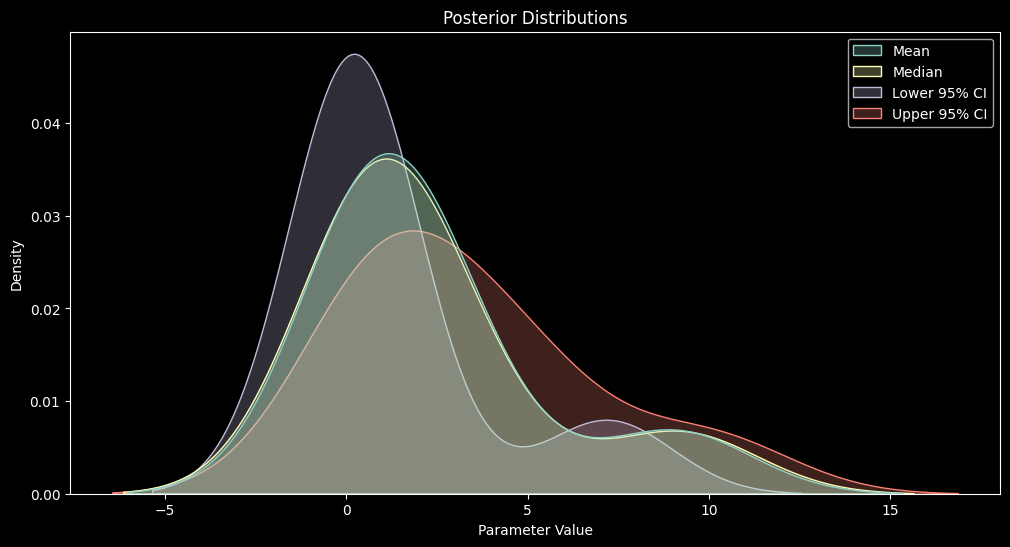

In [ ]:
# Plot Posterior distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(data=posterior_df, fill=True)
plt.title("Posterior Distributions")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.show()


Interpretation of the posterior estimates:
1. s: This parameter represents the susceptibility to the disease. A higher value indicates a higher susceptibility.
2. t: This parameter represents the transmission rate of the disease. A higher value indicates a higher transmission rate.
3. k: This parameter represents the shape parameter of the gamma distribution used to model the transmission rate. A higher value indicates a more skewed distribution.
4. intercept: This parameter represents the intercept of the linear regression model used to predict the transmission rate. A higher value indicates a higher baseline transmission rate.
smoothparam: This parameter represents the smoothing parameter of the spline used to model the transmission rate over time. A higher value indicates a smoother spline.
5. init_p1 and init_p2: These parameters represent the initial proportions of the two variants in the population. A higher value indicates a higher initial proportion.


mymodel = Model(Agent, 100, 0.1)
mypriors = [np.random.normal(1,1,200000), np.random.exponential(0.3,200000), np.random.exponential(3,200000),np.random.normal(0,1,200000),np.random.exponential(1,200000), np.random.normal(0, 1, 2000000)]
mymodel.inference(data, 10000, 100, mypriors)